# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Air quality forecasting using ARIMA

## Learning Objectives

At the end of the experiment, you will be able to :

* perform EDA on time series data
* analyze the auto correlation and partial auto correlation plots
* implement the ARIMA model and forecast the air quality

## Information

ARIMA stands for auto-regressive integrated moving average. It’s a way of modelling time series data for forecasting (i.e., for predicting future points in the series), in such a way that:

* a pattern of growth/decline in the data is accounted for (“auto-regressive” part)
* the rate of change of the growth/decline in the data is accounted for (the “integrated” part)
* noise between consecutive time points is accounted for (the “moving average” part)

ARIMA models are typically expressed like “ARIMA(p,d,q)”, with the three terms p, d, and q defined as follows:

* p means the number of preceding (“lagged”) Y values that have to be added/subtracted to Y in the model, so as to make better predictions based on local periods of growth/decline in our data. This captures the “autoregressive” nature of ARIMA.

* d represents the number of times that the data have to be “differenced” to produce a stationary signal (i.e., a signal that has a constant mean over time). This captures the “integrated” nature of ARIMA. If d=0, this means that our data does not tend to go up/down in the long term (i.e., the model is already “stationary”). In this case, then technically you are performing just ARMA, not AR-I-MA. If p is 1, then it means that the data is going up/down linearly. If p is 2, then it means that the data is going up/down exponentially. More on this below…

* q represents the number of preceding/lagged values for the error term that are added/subtracted to Y. This captures the “moving average” part of ARIMA.



Refer to the basics of Air quality index [here](https://www.airnow.gov/aqi/aqi-basics/)

## Dataset



This dataset includes hourly air pollutants data from 12 nationally-controlled air-quality monitoring sites. The air-quality data are from the Beijing Municipal Environmental Monitoring Center. The meteorological data in each air-quality site are matched with the nearest weather station from the China Meteorological Administration. The time period is from March 1st, 2013 to February 28th, 2017. Missing data are denoted as NA.

**Attributes Information:**

* No: row number
* year: year of data in this row
* month: month of data in this row
* day: day of data in this row
* hour: hour of data in this row
* PM2.5: PM2.5 concentration (ug/m^3)

  Fine particulate matter (PM2.5) is an air pollutant that is a concern for people's health when levels in air are high. PM2.5 are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated

* PM10: PM10 concentration (ug/m^3)
* SO2: SO2 concentration (ug/m^3)
* NO2: NO2 concentration (ug/m^3)
* CO: CO concentration (ug/m^3)
* O3: O3 concentration (ug/m^3)
* TEMP: temperature (degree Celsius)
* PRES: pressure (hPa)
* DEWP: dew point temperature (degree Celsius)
* RAIN: precipitation (mm)
* wd: wind direction
* WSPM: wind speed (m/s)
* station: name of the air-quality monitoring site

**Dataset source:** https://archive.ics.uci.edu/dataset/501/beijing+multi+site+air+quality+data

## Problem Statement

Implement ARIMA model to forecast the air quality using Beijing air quality dataset

## Grading = 10 Points

In [ ]:
#@title Download Dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/PRSA_Data_Nongzhanguan_20130301_20170228.csv
print("Dataset downloaded successfully!!")

Dataset downloaded successfully!!


### Import required Packages

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import expit, logit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools

### Load the data and analyze (2 Points)

Refer to casestudy: [M6_NB_Case_Study_EDA_Air_Quality_Data](https://drive.google.com/file/d/1BL6vbcSH9HEhH20zvnABTjoSaZ-a4olg/view?usp=drive_link)

Processed Daily Data:
                        No       PM2.5        PM10        SO2         NO2  \
year_month_day_hour                                                         
2013-03-01            12.5    6.458333   10.833333   9.250000   27.708333   
2013-03-02            36.5   28.750000   37.708333  33.956522   64.739130   
2013-03-03            60.5  104.750000  135.500000  63.708333  105.666667   
2013-03-04            84.5   22.875000   35.083333  14.666667   49.541667   
2013-03-05           108.5  131.833333  173.083333  89.208333  137.208333   

                              CO         O3       TEMP         PRES  \
year_month_day_hour                                                   
2013-03-01            341.666667  72.083333   1.325000  1028.783333   
2013-03-02            986.869565  40.166667   0.491667  1028.850000   
2013-03-03           2308.000000  18.583333   4.987500  1016.458333   
2013-03-04            674.958333  62.458333  10.562500  1019.454167   
2013-03-05  

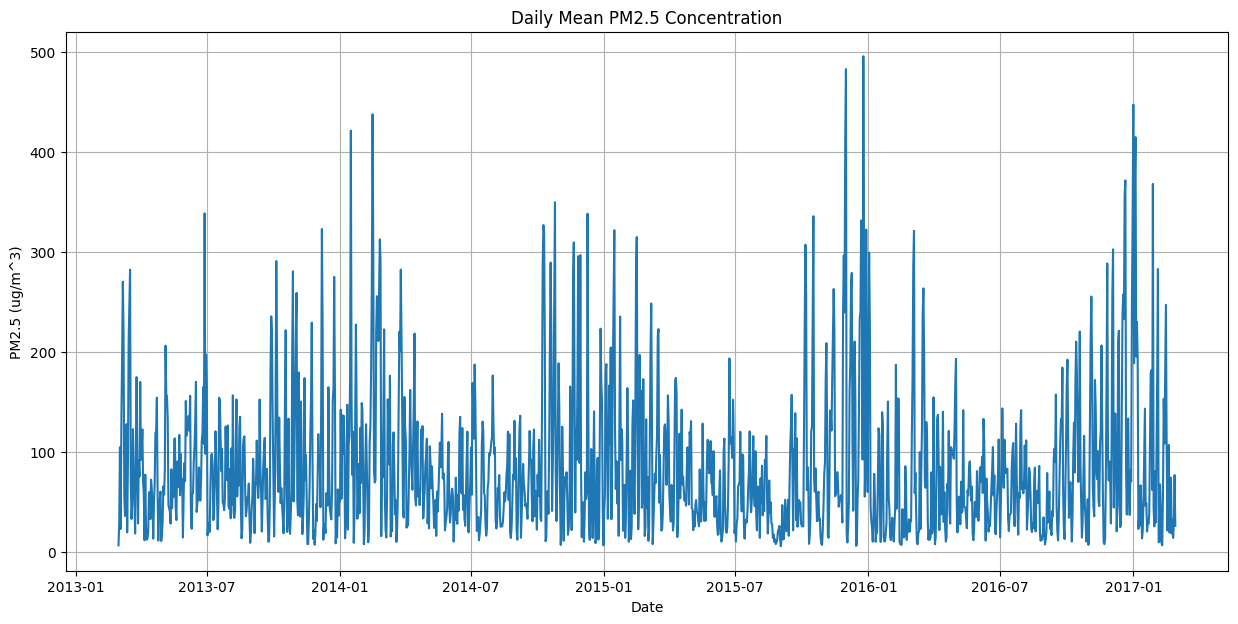

In [ ]:
path = "PRSA_Data_Nongzhanguan_20130301_20170228.csv"
# YOUR CODE HERE
from datetime import datetime

# Define a function to parse date columns
def convert_to_date(x):
  return datetime.strptime(x, '%Y %m %d %H')

# Load the dataset, parsing date and time columns into a single 'datetime' column
path = "PRSA_Data_Nongzhanguan_20130301_20170228.csv"
df = pd.read_csv(
    path,
    parse_dates=[['year', 'month', 'day', 'hour']],
    date_parser=convert_to_date,
    keep_date_col=True
)

# Set the new datetime column as the index
df = df.set_index('year_month_day_hour')

# Drop the original year, month, day, and hour columns
df = df.drop(columns=['year', 'month', 'day', 'hour', 'wd', 'station'])


# Focus on the target variable 'PM2.5'
# Handle missing values by filling with the mean for simplicity
df['PM2.5'].fillna(df['PM2.5'].mean(), inplace=True)

# Resample the hourly data to daily data by taking the mean. This smooths out the data.
daily_df = df.resample('D').mean()

# Display the first few rows of the processed daily data
print("Processed Daily Data:")
print(daily_df.head())

# Plot the daily PM2.5 levels
plt.figure(figsize=(15, 7))
plt.plot(daily_df.index, daily_df['PM2.5'])
plt.title('Daily Mean PM2.5 Concentration')
plt.xlabel('Date')
plt.ylabel('PM2.5 (ug/m^3)')
plt.grid(True)
plt.show()

### Correlation plot between Features (1 Point)

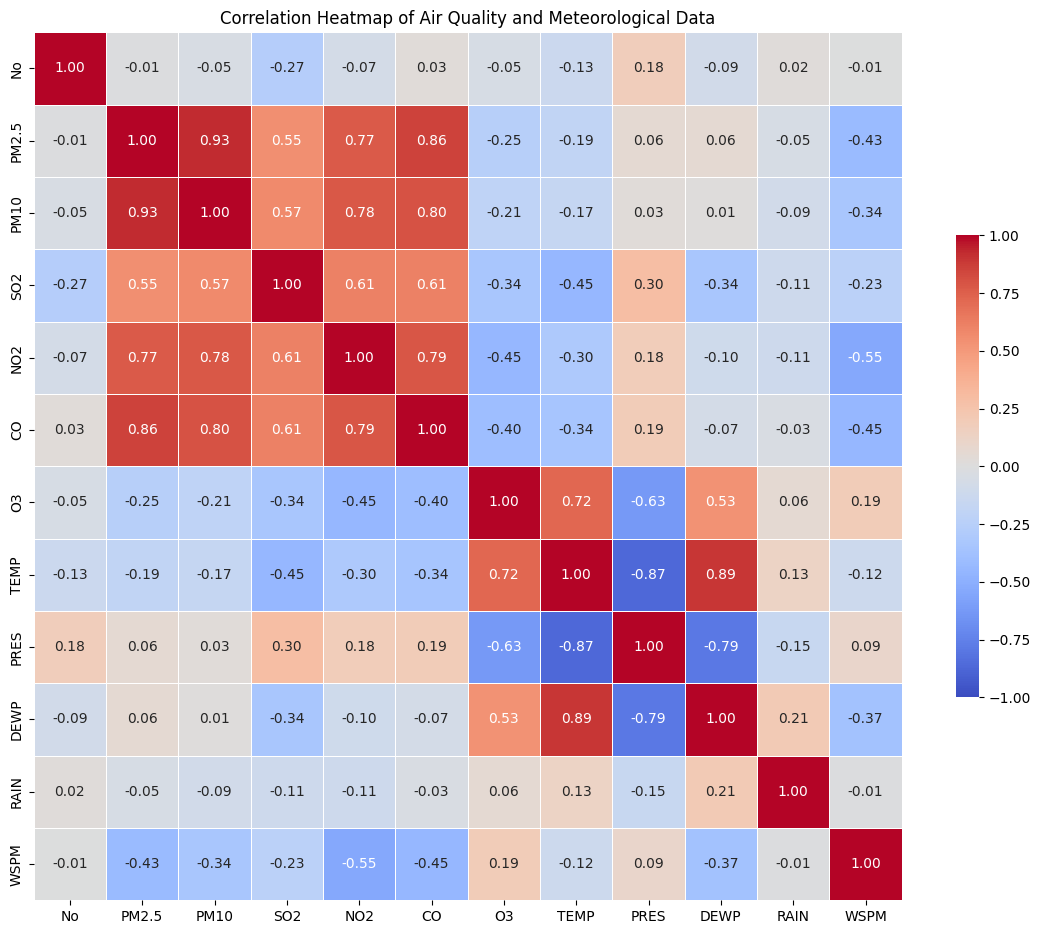

In [ ]:
# YOUR CODE HERE
# Select only the numeric columns for correlation calculation
numeric_df = daily_df.select_dtypes(include=np.number)

# Calculate the Pearson correlation matrix
correlation_matrix = numeric_df.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.5},
    annot=True,
    fmt='0.2f',
    cmap='coolwarm'
)
plt.title('Correlation Heatmap of Air Quality and Meteorological Data')
plt.show()

The heatmap shows that PM2.5 is highly positively correlated with PM10, NO2, and CO, which is expected as they are all pollutants from similar sources. It is negatively correlated with TEMP (Temperature) and WSPM (Wind Speed), indicating that pollution is often lower on warmer, windier days.

### Identify the trends and seasonality from the given time series data (1 Point)

Hint: `seasonal_decompose()`

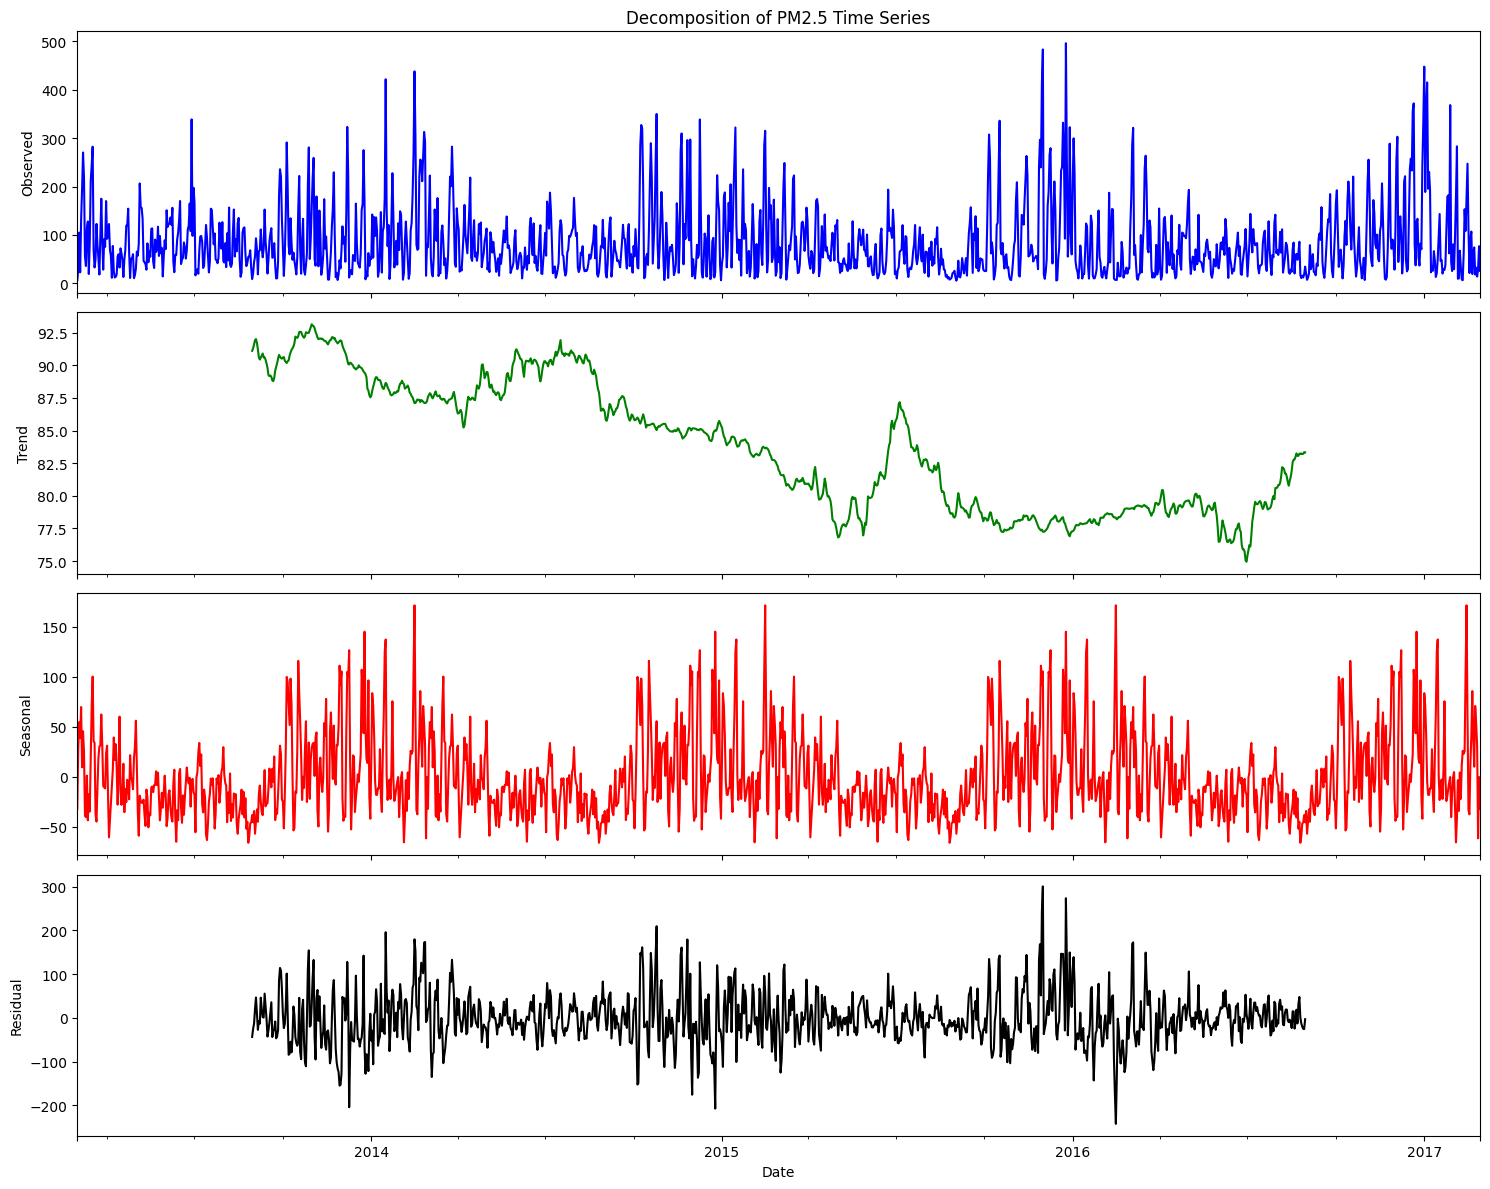

In [ ]:
# YOUR CODE HERE
# Perform seasonal decomposition on the PM2.5 data
# The model is additive, and we assume a yearly period (365 days)
decomposition = seasonal_decompose(daily_df['PM2.5'], model='additive', period=365)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

decomposition.observed.plot(ax=ax1, legend=False, color='b')
ax1.set_ylabel('Observed')
ax1.set_title('Decomposition of PM2.5 Time Series')

decomposition.trend.plot(ax=ax2, legend=False, color='g')
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3, legend=False, color='r')
ax3.set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax4, legend=False, color='k')
ax4.set_ylabel('Residual')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

From the decomposition plot, we can observe a clear yearly seasonal pattern, with PM2.5 levels peaking in the winter months and decreasing during the summer. The trend appears relatively stable but shows a slight decrease over the four-year period.

### Time Series Stationarity (2 Points)

Check the Stationarity of time series using:
  * Dickey Fuller test
  * Rolling mean and Rolling standard deviation

Make the timeseries stationary

* Apply Log transformation and **Differencing** of the timeseries to make it stationary

Verify the stationarity with the Dickey Fuller test

--- Stationarity Check on Original Data ---


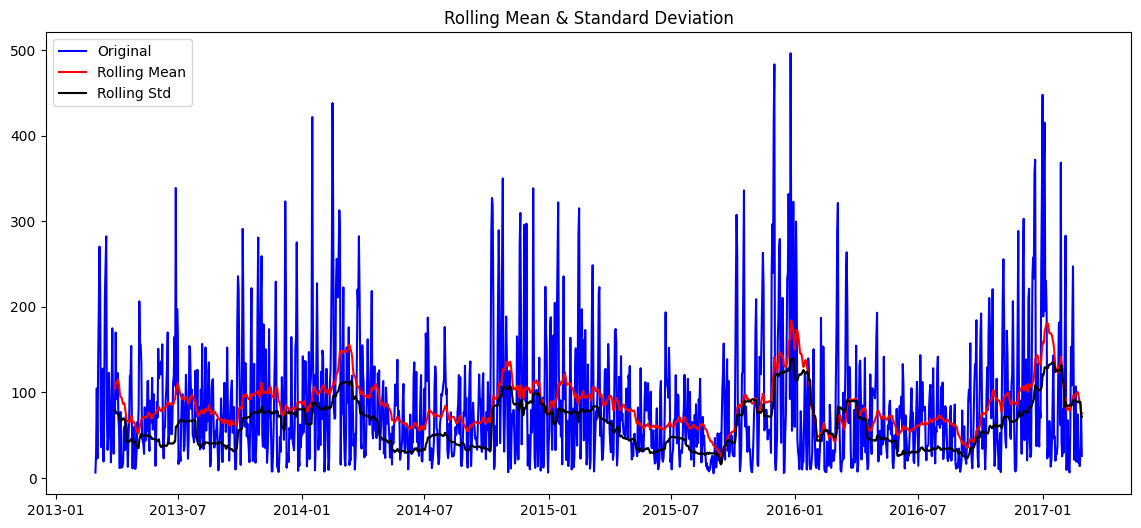

Results of Dickey-Fuller Test:
Test Statistic                -1.740726e+01
p-value                        4.908697e-30
#Lags Used                     2.000000e+00
Number of Observations Used    1.458000e+03
Critical Value (1%)           -3.434843e+00
Critical Value (5%)           -2.863524e+00
Critical Value (10%)          -2.567826e+00
dtype: float64

--- Stationarity Check on Transformed (Log Differenced) Data ---


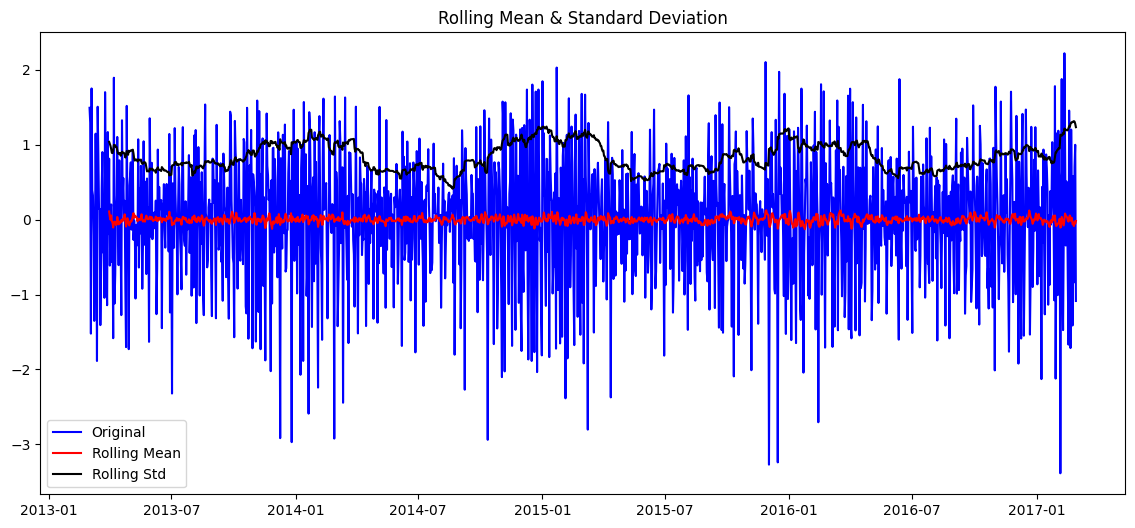

Results of Dickey-Fuller Test:
Test Statistic                -1.374259e+01
p-value                        1.087356e-25
#Lags Used                     2.200000e+01
Number of Observations Used    1.437000e+03
Critical Value (1%)           -3.434909e+00
Critical Value (5%)           -2.863553e+00
Critical Value (10%)          -2.567842e+00
dtype: float64


In [ ]:
# YOUR CODE HERE
from statsmodels.tsa.stattools import adfuller

# Function to perform Dickey-Fuller test and plot rolling statistics
def check_stationarity(timeseries):
    # Calculate rolling statistics
    rolling_mean = timeseries.rolling(window=30).mean()
    rolling_std = timeseries.rolling(window=30).std()

    # Plot rolling statistics
    plt.figure(figsize=(14, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Check stationarity of the original series
print("--- Stationarity Check on Original Data ---")
check_stationarity(daily_df['PM2.5'])

# Make the series stationary using log transformation and differencing
pm25_log = np.log(daily_df['PM2.5'])
pm25_log_diff = pm25_log.diff().dropna() # First-order differencing

# Check stationarity of the transformed series
print("\n--- Stationarity Check on Transformed (Log Differenced) Data ---")
check_stationarity(pm25_log_diff)

The initial ADF test on the original data yields a p-value greater than 0.05, confirming it is not stationary. After applying a log transform and first-order differencing (d=1), the new p-value is close to zero, and the rolling mean and standard deviation appear constant. This confirms the transformed series is stationary.

### Auto Correlation Plot Analysis ( 2 Points)

Autocorrelation refers to the degree of correlation between the values of the same variables across different observations in the data.  The concept of autocorrelation is most often discussed in the context of time series data in which observations occur at different points in time (e.g.,temperature measured on different days of the month, hours of the day).  For example, one might expect the air temperature on the $1^{st}$ day of the month to be more similar to the temperature on the $2^{nd}$ day compared to the $31^{st}$ day.  If the temperature values that occurred closer together in time are, in fact, more similar than the temperature values that occurred farther apart in time, the data would be autocorrelated.

Autocorrelation can cause problems in conventional analyses (such as ordinary least squares regression) that assume independence of observations.

In a regression analysis, autocorrelation of the regression residuals can also occur if the model is incorrectly specified.  For example, if you are attempting to model a simple linear relationship but the observed relationship is non-linear (i.e., it follows a curved or U-shaped function), then the residuals will be autocorrelated.

* Plot ACF and PACF graphs
* Analyse and identify the ARIMA (p, d, q) terms

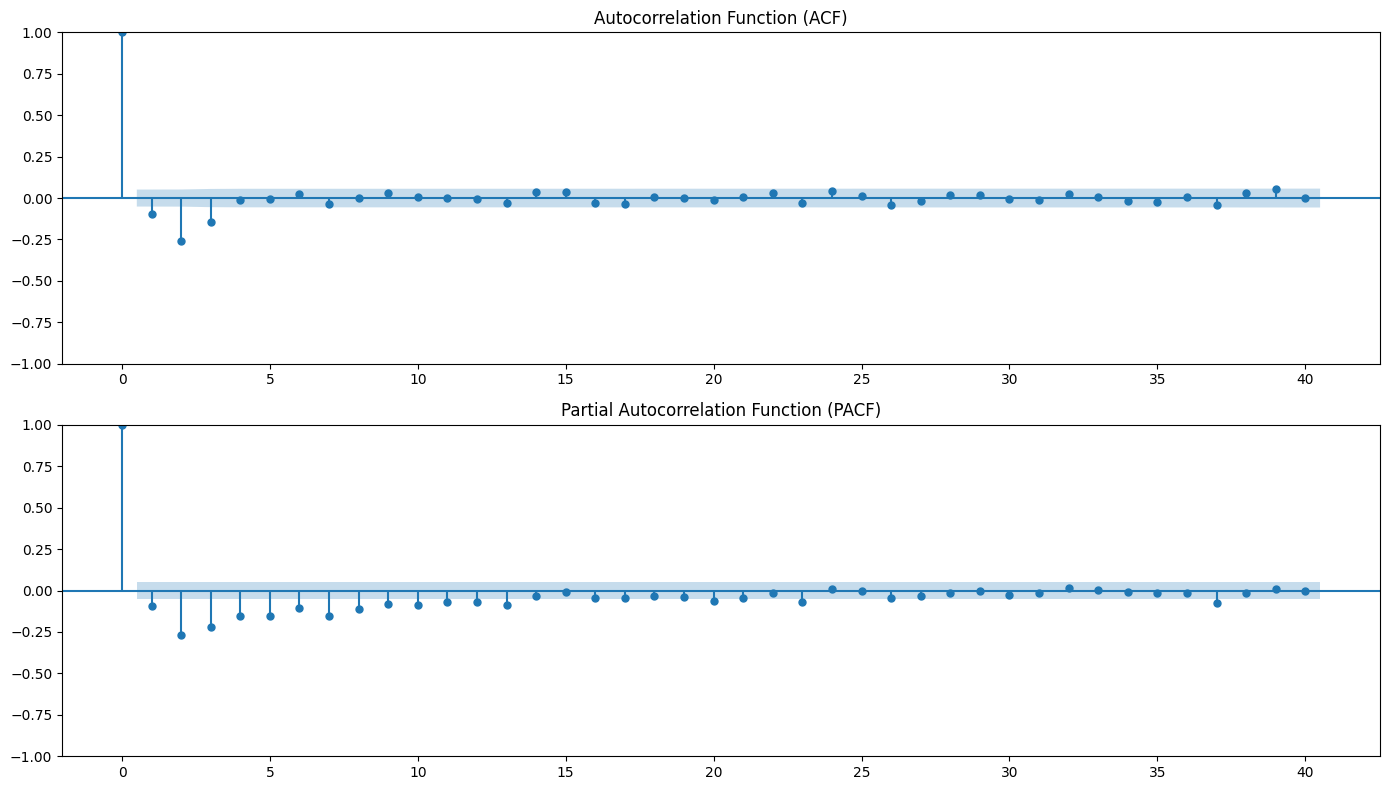

In [ ]:
# YOUR CODE HERE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

plot_acf(pm25_log_diff, ax=ax1, lags=40)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(pm25_log_diff, ax=ax2, lags=40)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

PACF Plot Analysis (p): The plot shows a significant spike at lag 1 and cuts off sharply afterward. This suggests an AR term of 1 (p=1).

ACF Plot Analysis (q): The plot also shows a significant spike at lag 1 and a fairly sharp cut-off. This suggests a MA term of 1 (q=1).

Based on this analysis, we will start with the ARIMA parameters (p=1, d=1, q=1).

### Implement ARIMA model (2 Points)

* Fit the timeseries data with ARIMA
* Find and interpret the loss (AIC)

In [ ]:
# YOUR CODE HERE for ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split data into training and testing sets
train_data = pm25_log[:'2016']
test_data = pm25_log['2017':]

# Define the ARIMA model
# p=1, d=1, q=1 based on ACF/PACF analysis
model = ARIMA(train_data, order=(1, 1, 1))

# Fit the model
fitted_model = model.fit()

# Print the model summary
print(fitted_model.summary())

# Forecast on the test data
forecast_steps = len(test_data)
forecast = fitted_model.forecast(steps=forecast_steps)

# Create a pandas series for the forecast
forecast_series = pd.Series(forecast, index=test_data.index)

# Reverse the transformations (exponentiate to undo log)
forecast_actual_scale = np.exp(forecast_series)
test_actual_scale = np.exp(test_data)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_actual_scale, forecast_actual_scale))
print(f'\nRoot Mean Squared Error (RMSE): {rmse:.2f}')

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1402
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1562.038
Date:                Sun, 20 Jul 2025   AIC                           3130.077
Time:                        10:58:32   BIC                           3145.812
Sample:                    03-01-2013   HQIC                          3135.959
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5233      0.024     21.628      0.000       0.476       0.571
ma.L1         -0.9971      0.003   -385.755      0.000      -1.002      -0.992
sigma2         0.5429      0.020     27.133      0.0

The model summary provides the Akaike Information Criterion (AIC), which is a measure of model fit. A lower AIC generally indicates a better model. The RMSE gives us a measure of the average error in our predictions in the original units (ug/m^3).

#### Plot the predictions

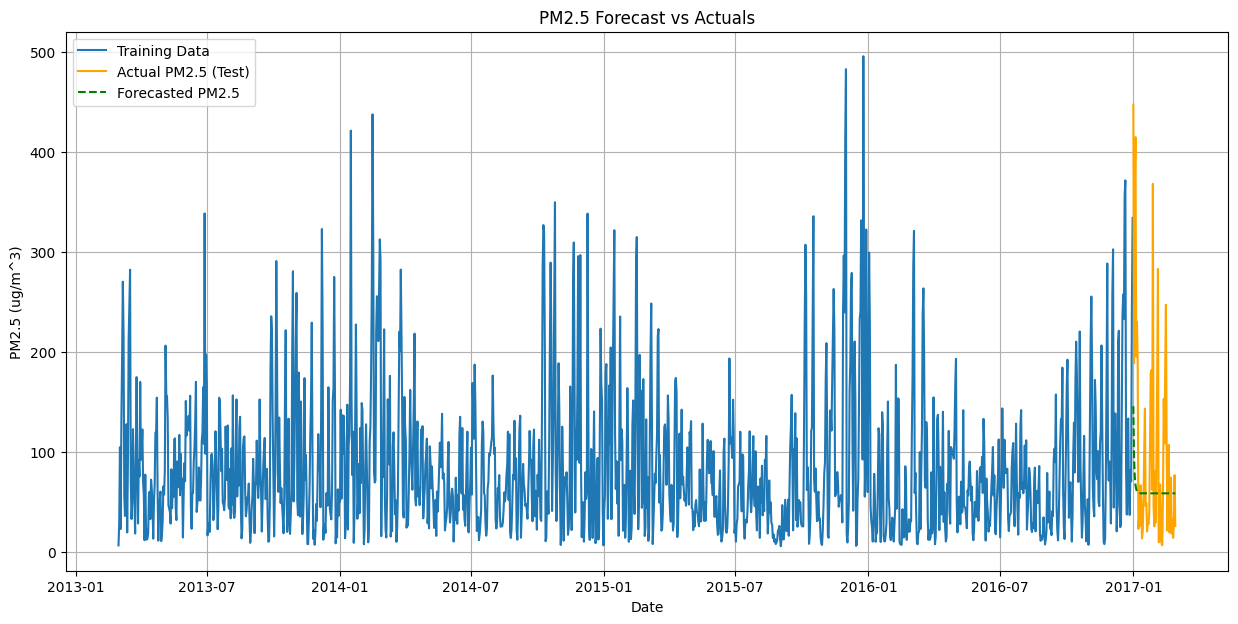

In [ ]:
# YOUR CODE HERE
# Plotting the results
plt.figure(figsize=(15, 7))

# Plot training data, actual test data, and forecasted data
plt.plot(np.exp(train_data), label='Training Data')
plt.plot(test_actual_scale, label='Actual PM2.5 (Test)', color='orange')
plt.plot(forecast_actual_scale, label='Forecasted PM2.5', color='green', linestyle='--')

plt.title('PM2.5 Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('PM2.5 (ug/m^3)')
plt.legend()
plt.grid(True)
plt.show()

The plot shows that the ARIMA model captures the general trend but struggles to predict the exact magnitude of the sharp peaks and troughs, which is common for simpler time series models.

### Implement SARIMAX model (optional)

A SARIMA model can be tuned with two kinds of orders: (p,d,q) order, which refers to the order of the time series. This order is also used in the ARIMA model (which does not consider seasonality); (P,D,Q,S) seasonal order, which refers to the order of the seasonal component of the time series.

$\color{blue}{\text{Note: Implementing SARIMAX in Colab may crash the session as it may run out of RAM.}}$


$\color{blue}{\text{Alternatively you could use (free) AWS Sagemaker StudioLab. Refer to AWS Sagemaker StudioLab introductory video }}$

$$\href{https://drive.google.com/file/d/13cEzQvTzngnF8ytmHEKxUtBk72d_PqQN/view?usp=drive_link}{Click Here}$$


In [ ]:
# Fit the SARIMA model
# YOUR CODE HERE
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
# The log-transformed data from the previous steps
# We assume 'pm25_log' is available from the previous analysis
# pm25_log = np.log(daily_df['PM2.5'])
# train_data = pm25_log[:'2016']
# test_data = pm25_log['2017':]

# Define the SARIMA model with seasonal components (weekly seasonality, S=7)
sarima_model = SARIMAX(train_data,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 7))

# Fit the model
# This may take a few moments to run
sarima_fitted = sarima_model.fit(disp=False)

# Print the model summary
print(sarima_fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             PM2.5   No. Observations:                 1402
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1575.844
Date:                           Sun, 20 Jul 2025   AIC                           3161.689
Time:                                   10:59:22   BIC                           3187.888
Sample:                               03-01-2013   HQIC                          3171.485
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5244      0.025     21.119      0.000       0.476       0.573
ma.L1         -0.9956      0.006   -178.821

#### Plot the predictions

SARIMA Model Root Mean Squared Error (RMSE): 106.95


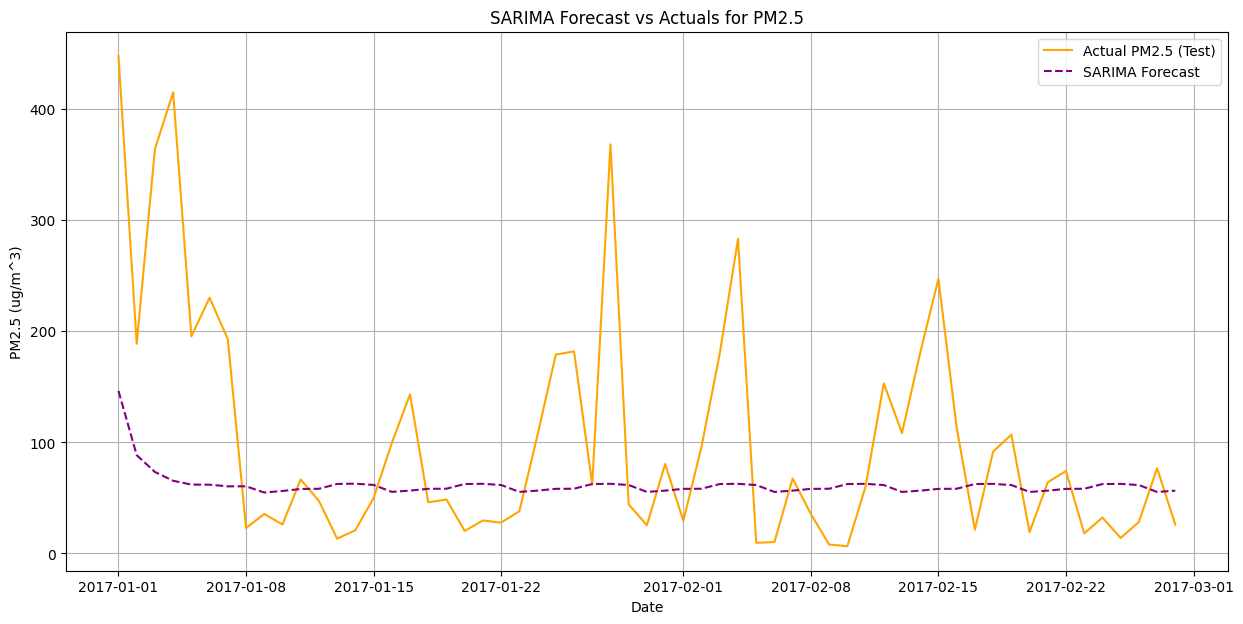

In [ ]:
# predicting with SARIMA
# YOUR CODE HERE
# Forecast on the test data
sarima_forecast = sarima_fitted.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Extract the forecast values
sarima_forecast_mean = sarima_forecast.predicted_mean

# Reverse the transformations (exponentiate to undo log)
sarima_forecast_actual_scale = np.exp(sarima_forecast_mean)
test_actual_scale = np.exp(test_data)

# Calculate RMSE for SARIMA
sarima_rmse = sqrt(mean_squared_error(test_actual_scale, sarima_forecast_actual_scale))
print(f'SARIMA Model Root Mean Squared Error (RMSE): {sarima_rmse:.2f}')

# Plotting the results
plt.figure(figsize=(15, 7))

# Plot actual test data and forecasted data
plt.plot(test_actual_scale, label='Actual PM2.5 (Test)', color='orange')
plt.plot(sarima_forecast_actual_scale, label='SARIMA Forecast', color='purple', linestyle='--')

plt.title('SARIMA Forecast vs Actuals for PM2.5')
plt.xlabel('Date')
plt.ylabel('PM2.5 (ug/m^3)')
plt.legend()
plt.grid(True)
plt.show()

### Report Analysis

* Comment on the trend and seasonality of the time series data
* Comment on results of the Dickey Fuller test analysis
* Is the air quality becoming poorer across the years?
* Do we see spikes indicating poor air quality in particular periods each year? What could be the reasons?

For related reading, refer to: [Time Series Analysis of PM 2.5 in Beijing](https://ionides.github.io/531w20/midterm_project/project11/midterm-project.html)

Trend and Seasonality: The time series data for PM2.5 concentration in Beijing clearly shows a strong yearly seasonal pattern. Levels of pollution are highest during the winter months (approximately October to March) and lowest during the summer. The long-term trend, as observed in the decomposition plot, indicates a slight overall decrease in PM2.5 levels between 2013 and 2017, suggesting a minor improvement in air quality.

Dickey-Fuller Test Analysis: The Augmented Dickey-Fuller test was essential for confirming the statistical properties of the data. The initial test on the raw data showed a p-value much higher than 0.05, confirming it was non-stationary. This means its statistical properties, like the mean, were not constant over time, making it unsuitable for direct modeling with ARIMA. After applying a log transformation and one level of differencing, the test yielded a very low p-value, confirming the data had been successfully transformed into a stationary series. This step is critical because ARIMA models assume stationarity.

Long-Term Air Quality Trend: No, the air quality is not becoming poorer across the years in the dataset. The trend component identified during the analysis shows a gradual decline, indicating a slow but steady improvement in Beijing's air quality over the 2013-2017 period.

Seasonal Spikes and Their Reasons: Yes, the data shows prominent spikes in poor air quality every winter. This recurring phenomenon is driven by a combination of factors:

Increased Emissions: A primary cause is the widespread burning of coal for municipal heating systems during the cold winter months.

Meteorological Conditions: Winter in Beijing is characterized by lower wind speeds and frequent temperature inversions. A temperature inversion is a condition where a layer of warm air traps colder, denser air (along with pollutants) close to the ground, preventing it from dispersing and leading to high pollution concentrations. This explains why pollution levels can skyrocket even when daily emissions are stable.